In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

%matplotlib inline 

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
holiday = pd.read_csv("holidays_events.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
transactions = pd.read_csv("transactions.csv")

train.head()

data = pd.concat([train,test])
data = data.merge(holiday, "left", ["date"]).rename(columns={"type" : "holiday_type"})
data = data.merge(stores, "left", ["store_nbr"]).rename(columns={'type':'city_type'})
data = data.merge(transactions, "left", ["store_nbr", "date"])
data = data.merge(oil, "left", ["date"])

data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'city', 'state', 'city_type', 'cluster', 'transactions', 'dcoilwtico'],
      dtype='object')

In [2]:

data.date = pd.to_datetime(data.date)
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.isocalendar().week
data['quarter'] = data['date'].dt.quarter
data['day_name'] = data['date'].dt.day_name()

data['dcoilwtico'] = data['dcoilwtico'].fillna(method='bfill')
data.transactions = data.transactions.replace(np.nan,0)
data['holiday_type'] = data['holiday_type'].replace(np.nan,'Working Day')
data['transferred'] = data['transferred'].replace(np.nan,False)

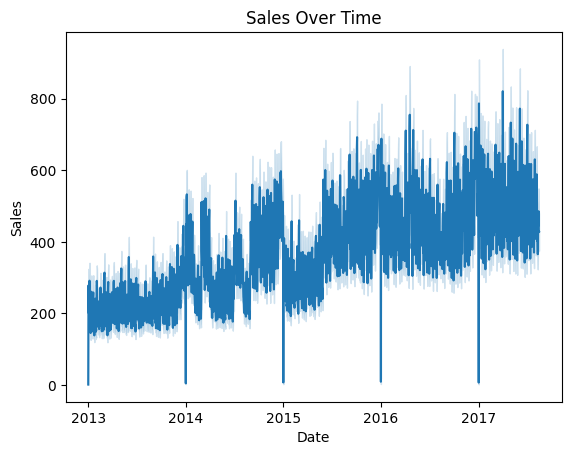

In [3]:
sns.lineplot(x='date', y='sales', data=data)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.show()

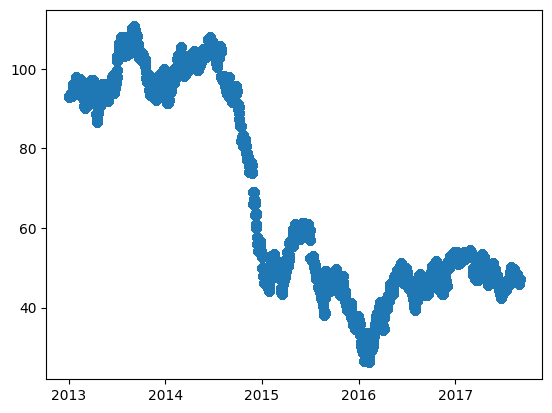

In [43]:
plt.scatter(x=data['date'], y=data['dcoilwtico'])

In [44]:
data['holiday_type'].unique()
data['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [4]:
a = data.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
px.bar(a, y = "family", x="sales", color = "family", title = "Product preferences")

In [5]:
dummies = pd.get_dummies(data[['store_nbr', 'family', 'sales', 'onpromotion',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'city', 'state', 'city_type', 'cluster', 'transactions', 'dcoilwtico']])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dummies[['store_nbr', 'sales', 'onpromotion', 'transferred',
         'cluster', 'transactions', 'dcoilwtico']] = scaler.fit_transform(dummies[[
                'store_nbr', 'sales', 'onpromotion', 'transferred', 'cluster',
                'transactions', 'dcoilwtico']])

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

dummies[['holiday_type']] = data[['holiday_type']]
dummies[['family']] = data[['family']]

filtered_train_data = dummies[data['date'] <= '2017-08-15']
filtered_test_data = dummies[data['date'] > '2017-08-15']

x_train = filtered_train_data[['store_nbr', 'dcoilwtico', 'transactions']]
x_test = filtered_test_data[['store_nbr', 'dcoilwtico', 'transactions']]
y_train = filtered_train_data['sales']

# Perform one-hot encoding on the 'holiday_type' column
encoder = OneHotEncoder(sparse=False, drop='first')
holiday_type_encoded = encoder.fit_transform(filtered_train_data[['holiday_type']])
x_train = np.hstack((x_train.values, holiday_type_encoded))

holiday_type_encoded = encoder.transform(filtered_test_data[['holiday_type']])
x_test = np.hstack((x_test.values, holiday_type_encoded))

# Perform one-hot encoding on the 'family' column
family_encoder = OneHotEncoder(sparse=False, drop='first')
family_encoded_train = family_encoder.fit_transform(filtered_train_data[['family']])
x_train = np.hstack((x_train, family_encoded_train))

family_encoded_test = family_encoder.transform(filtered_test_data[['family']])
x_test = np.hstack((x_test, family_encoded_test))

scaled_X_train = scaler.fit_transform(x_train)
scaled_X_test = scaler.transform(x_test)

# Fit the model and predict sales
model = LinearRegression()
model.fit(scaled_X_train, y_train)
predicted_sales = model.predict(scaled_X_test)

# Create the submission DataFrame
submission = pd.DataFrame({'id': filtered_test_data.index, 'sales': predicted_sales})
submission.to_csv('submission.csv', index=False)

c:\Users\valac\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

c:\Users\valac\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

dummies[['holiday_type']] = data[['holiday_type']]

filtered_train_data = dummies[data['date'] <= '2017-08-15']
filtered_test_data = dummies[data['date'] > '2017-08-15']

x_train = filtered_train_data[['store_nbr', 'dcoilwtico', 'transactions']]
x_test = filtered_test_data[['store_nbr', 'dcoilwtico', 'transactions']]
y_train = filtered_train_data['sales']

x_train = filtered_train_data[['store_nbr']]
x_test = filtered_test_data[['store_nbr']]
y_train = filtered_train_data['sales']

# Perform one-hot encoding on the 'holiday_type' column
encoder = OneHotEncoder(sparse=False, drop='first')
holiday_type_encoded = encoder.fit_transform(filtered_train_data[['holiday_type']])
x_train = np.hstack((x_train.values, holiday_type_encoded))

holiday_type_encoded = encoder.transform(filtered_test_data[['holiday_type']])
x_test = np.hstack((x_test.values, holiday_type_encoded))

scaled_X_train = scaler.fit_transform(x_train)
scaled_X_test = scaler.transform(x_test)

# Fit a Random Forest Regression model
model = RandomForestRegressor(n_estimators=100)
model.fit(scaled_X_train, y_train)
predicted_sales = model.predict(scaled_X_test)

# Ensure non-negative predictions
predicted_sales = np.maximum(predicted_sales, 0)

# Create the submission DataFrame
submission = pd.DataFrame({'id': filtered_test_data.index, 'sales': predicted_sales})
submission.to_csv('submission.csv', index=False)


c:\Users\valac\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



: 

: 

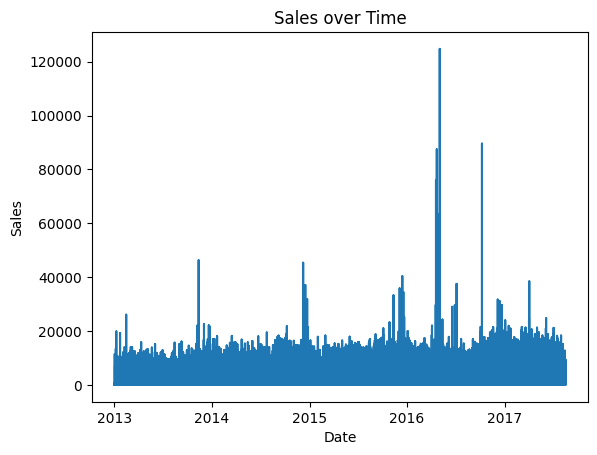

In [7]:
plt.plot(data['date'],data['sales'])
plt.title('Sales over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Text(0.5, 1.0, 'Residual Plot')

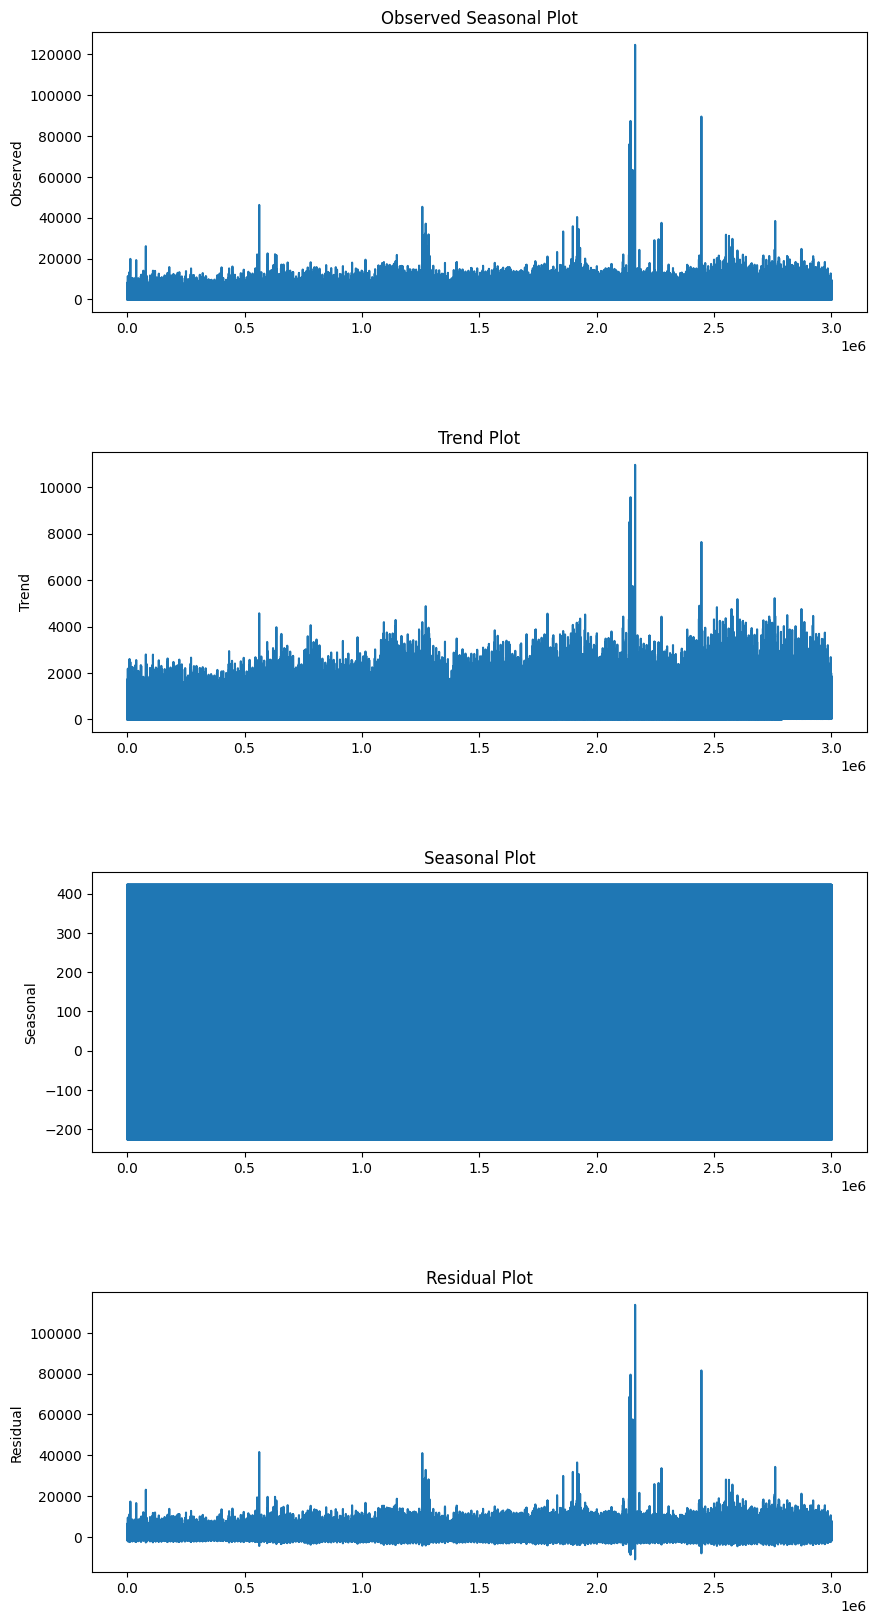

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series
decomposition = seasonal_decompose(train['sales'], model='additive', period=12)

# create a seasonal plot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,20))
fig.subplots_adjust(hspace=0.5) # added space between subplots

decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
axes[0].set_title('Observed Seasonal Plot')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend Plot')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
axes[2].set_title('Seasonal Plot')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_title('Residual Plot')

In [31]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
store_df = pd.read_csv('stores.csv')
tr_df = pd.read_csv('transactions.csv')
oil_df = pd.read_csv('oil.csv')
hol_df = pd.read_csv('holidays_events.csv')
sample_df = pd.read_csv('sample_submission.csv')

train_df.groupby(by='store_nbr')['sales'].sum()

family_map       = {'AUTOMOTIVE': 'rest',
                   'BABY CARE': 'rest',
                   'BEAUTY': 'rest',
                   'BOOKS': 'rest',
                   'CELEBRATION': 'rest',
                   'GROCERY II': 'rest',
                   'HARDWARE': 'rest',
                   'HOME AND KITCHEN I': 'rest',
                   'HOME AND KITCHEN II': 'rest',
                   'HOME APPLIANCES': 'rest',
                   'LADIESWEAR': 'rest',
                   'LAWN AND GARDEN': 'rest',
                   'LINGERIE': 'rest',
                   'MAGAZINES': 'rest',
                   'PET SUPPLIES': 'rest',
                   'PLAYERS AND ELECTRONICS': 'rest',
                   'SCHOOL AND OFFICE SUPPLIES': 'rest',
                   'SEAFOOD': 'rest',
                   'DELI': 'first_sec',
                    'EGGS': 'first_sec',
                    'FROZEN FOODS': 'first_sec',
                    'HOME CARE': 'first_sec',
                    'LIQUOR,WINE,BEER': 'first_sec',
                    'PREPARED FOODS': 'first_sec',
                    'PERSONAL CARE': 'first_sec',
                    'BREAD/BAKERY': 'third',
                    'MEATS': 'third',
                    'POULTRY': 'third',
                    'CLEANING':'fourth',
                    'DAIRY':'fourth',
                    'PRODUCE':'seventh',
                    'BEVERAGES':'fifth',
                    'GROCERY I': 'sixth'
                   }

train_df['new_family'] = train_df['family'].map(family_map)



for i in range(1,len(train_df.store_nbr.unique())+1):
    val = train_df[train_df.store_nbr == i].sales.quantile(0.99)
    train_df = train_df.drop(train_df[(train_df.store_nbr==i) & (train_df.sales > val)].index)

train_df[train_df.sales>0]
np.sort(train_df.store_nbr.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54], dtype=int64)

In [32]:

train_df = pd.merge(train_df, store_df, on='store_nbr', how='left') 

holiday_loc = hol_df[hol_df.locale == 'Local']
holiday_reg = hol_df[hol_df.locale == 'Regional']
holiday_nat = hol_df[hol_df.locale == 'National']

hol_df.rename(columns={'type': 'day_nature'},
          inplace=True, errors='raise')
holiday_loc.rename(columns={'locale_name': 'city'},
          inplace=True, errors='raise')
holiday_reg.rename(columns={'locale_name': 'state'},
          inplace=True, errors='raise')



train_df = pd.merge(train_df, holiday_loc, on=['date', 'city'], how='left') 
train_df = train_df[~((train_df.day_nature == 'Holiday') & (train_df.transferred == False))]
train_df.drop(['day_nature', 'locale', 'description','transferred'], axis=1, inplace=True)
train_df = pd.merge(train_df, holiday_reg, on=['date', 'state'], how='left') 
train_df = train_df[~((train_df.day_nature == 'Holiday') & (train_df.transferred == False))]
train_df.drop(['day_nature', 'locale', 'description','transferred'], axis=1, inplace=True)
train_df = pd.merge(train_df, holiday_nat, on=['date'], how='left') 
train_df = train_df[~((train_df.day_nature == 'Holiday') & (train_df.transferred == False))]
train_df.drop(['day_nature', 'locale', 'description','transferred'], axis=1, inplace=True)

train_df.drop(['id', 'date', 'family', 'month', 'day','city','state','type', 'cluster', 'locale_name', 'year'],axis=1, inplace=True)

train_df = pd.get_dummies(train_df, columns = ['day_name','new_family'])
train_df.reset_index(inplace=True)
train_df.drop(['index'],axis=1, inplace=True)


C:\Users\valac\AppData\Local\Temp\ipykernel_30756\1949018218.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\valac\AppData\Local\Temp\ipykernel_30756\1949018218.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



AttributeError: 'DataFrame' object has no attribute 'day_nature'

In [ ]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn import preprocessing


for i in range(1,len(train_df.store_nbr.unique())+1):  
    temp_df = train_df[train_df.store_nbr == i]
    sale_out = temp_df[['sales']]
    globals()['max_%s' % i] = temp_df['onpromotion'].max()
    temp_df['onpromotion'] = (temp_df['onpromotion']/globals()['max_%s' % i])
    temp_df.onpromotion = np.where(temp_df.onpromotion<0, 0, temp_df.onpromotion)
    temp_df.drop(['sales','store_nbr'],axis=1, inplace=True)
    globals()['model_%s' % i] = XGBRegressor(verbosity=0)
    globals()['model_%s' % i].fit(temp_df, sale_out)
    
test_df['day_name'] = pd.to_datetime(test_df['date']).dt.day_name()
test_df['new_family'] = test_df['family'].map(family_map)
test_df.drop(['date','family'],axis=1, inplace=True)
test_df = pd.get_dummies(test_df, columns = ['day_name','new_family'])

backup_df_1 = pd.DataFrame()

for i in range(1,len(train_df.store_nbr.unique())+1):
    temp_df = test_df[test_df.store_nbr == i]
    temp_df['onpromotion'] = (temp_df['onpromotion']/globals()['max_%s' % i])
    temp_df.onpromotion = np.where(temp_df.onpromotion<0, 0, temp_df.onpromotion)
    save_id = temp_df[['id']].reset_index()
    temp_df.drop(['id','store_nbr'],axis=1, inplace=True)
    submit = globals()['model_%s' % i].predict(temp_df)
    save_id['sales'] = submit
    df11 = pd.DataFrame(submit, columns = ['sales'])
    backup_df = pd.concat([save_id[['id']], df11], axis = 1, ignore_index = True)
    backup_df_1 = backup_df_1.append(backup_df, ignore_index=True)

backup_df_1.rename(columns={0 : "id", 1 : "sales"}, inplace=True, errors='raise')
test_df = pd.merge(test_df, backup_df_1, on='id', how='left') 

sample_df = test_df[['id', 'sales']]
sample_df.sales = np.where(sample_df.sales<0, 0, sample_df.sales)
sample_df.head(3)


sample_df.to_csv('submission.csv' , index = False)